In [32]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import math

def find_distance(start, end):
    '''finds distance between two 2D coordinates'''
    distance = math.sqrt(math.pow(start[0]-end[0], 2) + math.pow(start[1]-end[1], 2))
    print('find euclian distance', distance)
    return distance


def find_mmp_pi(altitude):
    ''' returns meters per pixel with altitude (meters) input. this
    function is based on specifications for Raspberry Pi+ Camera v1.3.
    image resoluton is 640x480 pixels, FOC_X = 53.50 & FOC_Y = 41.41'''
    radians =(53.50/2)*math.pi/180
    distance = math.tan(radians)*altitude
    mmp = distance/320
    return mmp
    
    
def find_mmp(altitude):
    ''' returns meters per pixel with altitude (meters) input. this
    function is based on specifications for Phantom Camera'''
    radians =(94/2)*math.pi/180
    print('radians', radians)
    distance = altitude * math.tan(radians)
    print('tan(radians)', math.tan(radians))
    print('altitude', altitude)
    print('distance', distance)
    mmp = distance/2500
    print('mmp', mmp)
    return mmp
    
def find_mps(seconds, altitude, pathStart, pathEnd):
    '''returns speed in meters per second'''
    
    # loads in timing photos taken from UAV imagery
    img1 = cv.imread(pathStart, cv.IMREAD_GRAYSCALE)
    img2 = cv.imread(pathEnd, cv.IMREAD_GRAYSCALE)

    # creates and saves template from the first photo
    x, y = img1.shape
    print(x, y)
    a, b = int(x*0.3334), int(x*0.6667)
    c, d = int(y*0.3334), int(y*0.6667)
    template = img1[a:b, c:d].copy()
    plt.imsave('template_a_b_c_d.jpg', template)
    midpoint_template = ((a+b)/2, (c+d)/2)
    
    # this loops through three different methods of determining 
    # matching location of the template within second photo and
    # finds an overall average best-fit rectangle midpoint
    avgMidpoint_match = (0, 0)
    methods = ['cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR_NORMED'] #'cv.TM_SQDIFF_NORMED']
    w, h = template.shape[::-1]
    for meth in methods:
        img = img2.copy()
        method = eval(meth)
        # Apply template Matching
        res = cv.matchTemplate(img,template,method)
        min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method == 'cv.TM_SQDIFF_NORMED':
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        # cv.rectangle takes in args (img, start_point, end_point, color, width)
        cv.rectangle(img,top_left, bottom_right, 255, 10)
        plt.imsave('{0}_template_match.png'.format(meth), img)
        avgMidpoint_match = (avgMidpoint_match[0]+top_left[1]+bottom_right[1],
                             avgMidpoint_match[1]+top_left[0]+bottom_right[0])
    avgMidpoint_match = (avgMidpoint_match[0]/(2*len(methods)), avgMidpoint_match[1]/(2*len(methods)))
    print('avg midpoint match', avgMidpoint_match)
    print('midpoint template', midpoint_template)

    # from coordinates of initial template in first photo and
    # coordinates of template found in second photo, determines
    # the approximate amount of distance traveled
    pixels = find_distance(midpoint_template, avgMidpoint_match)
    meters_per_pixel = find_mmp(altitude)
    return round((pixels*meters_per_pixel)/seconds, 5)

In [33]:
pathStart = '/Users/christinevankirk/Desktop/uav_nsf/Phantom_Photos_6-7-21/DJI_0062.JPG'
pathEnd   = '/Users/christinevankirk/Desktop/uav_nsf/Phantom_Photos_6-7-21/DJI_0059.JPG'
seconds   = 6
altitude  = 19.812

# finds meters per second
mps = find_mps(seconds, altitude, pathStart, pathEnd)
print(mps)

print('margin of error', (1.386-mps)/1.386)

3000 4000
avg midpoint match (532.5, 2208.0)
midpoint template (1500.0, 1999.5)
find euclian distance 989.7113215478541
radians 0.8203047484373349
tan(radians) 1.0723687100246826
altitude 19.812
distance 21.245768883009013
mmp 0.008498307553203605
1.40181
margin of error -0.011406926406926482


In [27]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

def find_mps_features(seconds, altitude, pathStart, pathEnd):

    # loads in timing photos taken from UAV imagery
    img1 = cv.imread(pathStart, cv.IMREAD_GRAYSCALE)
    
    # creates and saves template from the first photo
    x, y = img1.shape
    a, b = int(x*0.45), int(x*0.55)
    c, d = int(y*0.45), int(y*0.55)
    template = img1[a:b, c:d].copy()
    plt.imsave('template_a_b_c_d.jpg', template)
    midpoint_template = ((a+b)/2, (c+d)/2)
    
    plt.imshow(img1)
    cv.rectangle(img1,(c,a),(d,b), 255, 2)
    plt.show()
    
    plt.imshow(template),plt.show()
    
    img2 = cv.imread(pathEnd, cv.IMREAD_GRAYSCALE)
    
    plt.imshow(img2),plt.show()

    # Initiate SIFT detector
    sift = cv.SIFT_create()

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(template,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    # FLANN parameters
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks=50)   # or pass empty dictionary
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1,des2,k=2)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
#         help(type(m))
#         repr(m)
#         print('m')
#         print(m.distance)
#         print(m.imgIdx)
#         print(m.queryIdx)
#         print(m.trainIdx)
        if m.distance < 0.8*n.distance:
            matchesMask[i]=[1,0]
    
#     matches = sorted(matches, key = lambda x:x[0].distance)
    
#     # Draw first 10 matches.
#     img3 = cv.drawMatches(template,kp1,img2,kp2,matches[:10],None,flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
#     plt.imshow(img3),plt.show()

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = cv.DrawMatchesFlags_DEFAULT)
    img3 = cv.drawMatchesKnn(template,kp1,img2,kp2,matches,None,**draw_params)
    plt.imshow(img3),plt.show()
# plt.imsave('{0}_{1}.png'.format(name1, name2), img3)

In [4]:
pathStart = '/Volumes/USB/Phantom_Photos_6-7-21/DJI_0062.JPG'
pathEnd   = '/Volumes/USB/Phantom_Photos_6-7-21/DJI_0063.JPG'
seconds   = 2
altitude  = 19.812

# finds meters per second
mps = find_mps(seconds, altitude, pathStart, pathEnd)
print(mps)

453.5


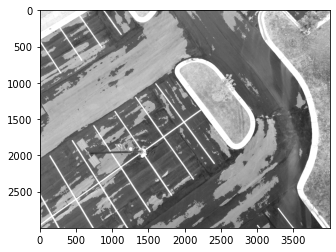

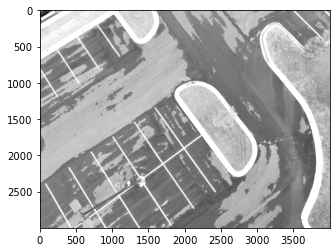

3000 4000 1000 2000 1333 2666


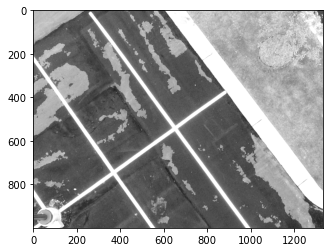

(1333, 1000)
(2666, 2000)


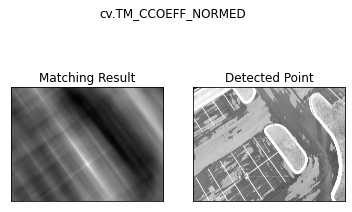

(1334, 1360)
(2667, 2360)


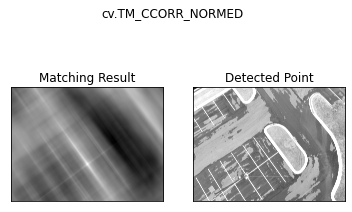

(1334, 1360)
(2667, 2360)


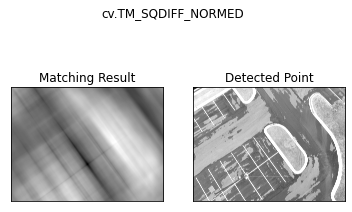

(1334, 1360)
(2667, 2360)


In [23]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

# returns speed in meters per second
img1 = cv.imread('/Volumes/USB/Phantom_Photos_6-7-21/DJI_0062.JPG', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('/Volumes/USB/Phantom_Photos_6-7-21/DJI_0063.JPG', cv.IMREAD_GRAYSCALE)

plt.imshow(img1, cmap = 'gray')
plt.show()

plt.imshow(img2, cmap = 'gray')
plt.show()

# template is the smaller one
# template = cv.imread('/Volumes/AC_BACKUP/aerial_dataset/AerialImageDataset/train/template_matching/chicago9_template.tif',0)
x, y = img1.shape
a, b = int(x*0.3334), int(x*0.6667)
c, d = int(y*0.3334), int(y*0.6667)
print(x, y, a, b, c, d)
template = img1[a:b, c:d].copy()
plt.imsave('template_a_b_c_d.jpg', template)

temp_topL = (c, a)
temp_bottomR = (d, b)

plt.imshow(template, cmap = 'gray')
plt.show()

print(temp_topL)
print(temp_bottomR)

w, h = template.shape[::-1]

# All the 6 methods for comparison in a list
# methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
#            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
methods = ['cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    # cv.rectange(img, start_point, end_point, color, width)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()
    plt.imsave('{0}_template_match.png'.format(meth), img)

    print(top_left)
    print(bottom_right)